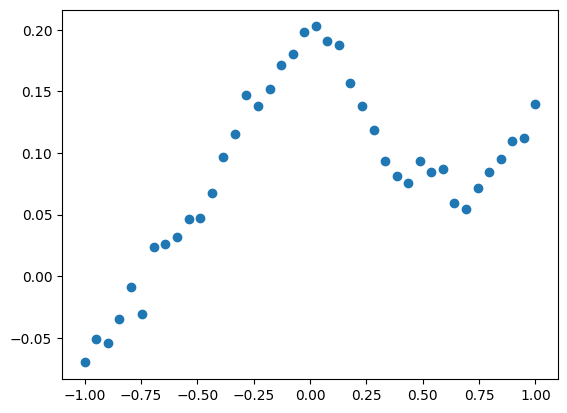

In [52]:
# Generate data
u = np.linspace(-1, 1, m)
v = 1 / (5 + 40 * u**2) + 0.1 * u**3 + 0.01 * np.random.randn(1, m)
v = v.T

plt.scatter(u, v, label='data')

### Spline fit without constraints results in discontinuity

In [67]:

# Fit 3 polynomials in the range -1 <= u <= -1/3, -1/3 <= u <= 1/3, 1/3 <= u <= 1
# p(x) = a0 + a1*x + a2*x^2 + a3*x^3
# p'(x) = a1 + 2*a2*x + 3*a3*x^2
# p''(x) = 2*a2 + 6*a3*x

n = 4
a, b = -1/3, 1/3

u1 = u[u < a]
u2 = u[(u >= a) & (u < b)]
u3 = u[u >= b]

A1 = np.vander(u1, n, increasing=True)
A2 = np.vander(u2, n, increasing=True)
A3 = np.vander(u3, n, increasing=True)

a1 = cp.Variable((4, 1))
a2 = cp.Variable((4, 1))
a3 = cp.Variable((4, 1))

constraints = []
#objective = cp.Minimize(cp.sum_squares(A1 @ a1 - v[u < a]) + cp.sum_squares(A2 @ a2 - v[(u >= a) & (u < b)]) + cp.sum_squares(A3 @ a3 - v[u >= b]))
objective = cp.Minimize(cp.norm2(v - cp.vstack([A1 @ a1, A2 @ a2, A3 @ a3])))
problem = cp.Problem(objective, constraints)
problem.solve()
print("Status:", problem.status)

Status: optimal


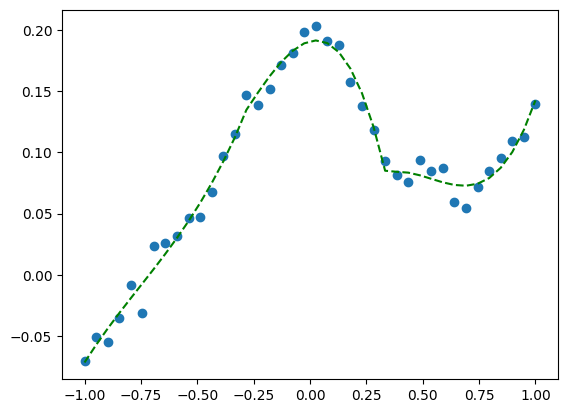

In [68]:
plt.scatter(u, v, label='data')
plt.plot(u, np.vstack([A1 @ a1.value, A2 @ a2.value, A3 @ a3.value]), '--g',label='fit')

### Let's re-try the fit with constraints

In [89]:
def p(x):
    return [1, x, x**2, x**3]

def p_1st_deriv(x):
    return [0, 1, 2*x, 3*x**2]

def p_2nd_deriv(x):
    return [0, 0, 2, 6*x]

def solve(norm='l2'):
    a1 = cp.Variable((4, 1))
    a2 = cp.Variable((4, 1))
    a3 = cp.Variable((4, 1))

    constraints = [
        # continuity at a
        p(a) @ a1 == p(a) @ a2,
        p_1st_deriv(a) @ a1 == p_1st_deriv(a) @ a2,
        p_2nd_deriv(a) @ a1 == p_2nd_deriv(a) @ a2,

        # continuity at b
        p(b) @ a2 == p(b) @ a3,
        p_1st_deriv(b) @ a2 == p_1st_deriv(b) @ a3,
        p_2nd_deriv(b) @ a2 == p_2nd_deriv(b) @ a3,
    ]

    if norm == 'inf':
        print("Computing splines in the case of L-inf-norm...")
        objective = cp.Minimize(cp.norm_inf(v - cp.vstack([A1 @ a1, A2 @ a2, A3 @ a3])))
    else:
        print("Computing splines in the case of L2-norm...")
        objective = cp.Minimize(cp.norm2(v - cp.vstack([A1 @ a1, A2 @ a2, A3 @ a3])))

    problem = cp.Problem(objective, constraints)
    problem.solve()
    print("Status:", problem.status)

    return a1.value, a2.value, a3.value

Computing splines in the case of L2-norm...
Status: optimal
Computing splines in the case of L-inf-norm...
Status: optimal


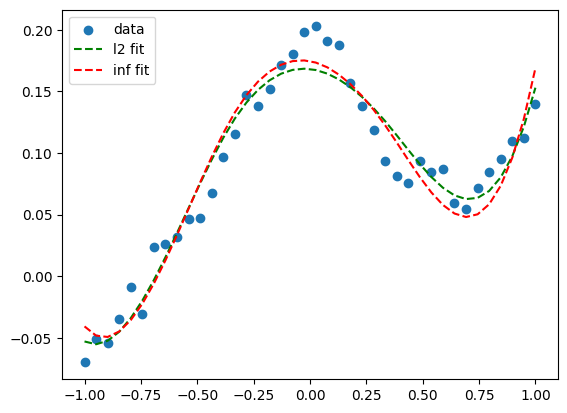

In [90]:
plt.scatter(u, v, label='data')
a1, a2, a3 = solve()
plt.plot(u, np.vstack([A1 @ a1, A2 @ a2, A3 @ a3]), '--g',label='l2 fit')
a1, a2, a3 = solve(norm='inf')
plt.plot(u, np.vstack([A1 @ a1, A2 @ a2, A3 @ a3]), '--r',label='inf fit')
plt.legend()